In [14]:
# Program To Read video 
# and Extract Frames 

# import sys
# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install moviepy

import cv2 
import os
import sys
import shutil
import numpy as np
import moviepy.video.io.ImageSequenceClip
from PIL import Image

In [50]:
def FrameCapture(path, vid_num): 
      
    # Path to video file 
    vidObj = cv2.VideoCapture(path) 
  
    # Used as counter variable 
    count = 0
    success = 1
    images=[]
    try:
        shutil.rmtree("lebron_dunk" + str(vid_num))
        os.mkdir("lebron_dunk" + str(vid_num))
    except OSError as e:
        os.mkdir("lebron_dunk" + str(vid_num))
    while success: 
  
        # vidObj object calls read 
        # function extract frames 
        success, image = vidObj.read() 
        # Saves the frames with frame-count 
        if image is not None and len(image) > 0:
            cv2.imwrite("lebron_dunk" + str(vid_num) + "/frame" + str(1000+count) + ".jpg", image) 
            img = Image.open("lebron_dunk" + str(vid_num) + "/frame" + str(1000+count) + ".jpg")
            img = img.resize((img.size[0]//10, img.size[1]//10), Image.ANTIALIAS)
            img.save("lebron_dunk" + str(vid_num) + "/frame" + str(1000+count) + ".jpg")
            images.append(np.array(img))
        count += 1
    return images

In [ ]:
data = []
for i in range(1, 11):
    temp = FrameCapture("movies/lebron_dunk" + str(i) + ".mp4", i)
    data.append(temp)

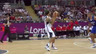

In [33]:
def recreate_movie(image_folder, new_name):
    fps=30
    image_files = [image_folder+'/'+img for img in os.listdir(image_folder) if img.endswith(".jpg")]
    image_files.sort()
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
    clip.write_videofile(new_name + '.mp4')

In [36]:
recreate_movie('lebron_dunk1', 'recreated_movies/lebron_1')

Moviepy - Building video recreated_movies/lebron_1.mp4.
Moviepy - Writing video recreated_movies/lebron_1.mp4

Moviepy - Done !
Moviepy - video ready recreated_movies/lebron_1.mp4


In [37]:
import torch 
import numpy as np

In [38]:
from torchvision import datasets, transforms

## YOUR CODE HERE ##
batch_size = 10
latent_dim = 10
transformations = transforms.ToTensor()
# mnist_train =  datasets.MNIST(loc_data, train=True, download=True, transform = transformations)
# mnist_test = datasets.MNIST(loc_data, train=False, download=True, transform = transformations)

In [40]:
images = data[0]
total_len = images[0].shape[0]*images[0].shape[1]

In [41]:
from torch.utils.data import DataLoader

train_loader = DataLoader(images,batch_size=batch_size,drop_last = True,shuffle=False)

In [46]:
from torch import nn
class Encoder(nn.Module):
  def __init__(self, latent_dim):
    super(Encoder, self).__init__()
    ## YOUR CODE HERE ##
    self.lin1 = nn.Linear(total_len, total_len//2)
    self.lin2 = nn.Linear(total_len//2, total_len//4)
    self.lin3a = nn.Linear(total_len//4, latent_dim)
    self.lin3b = nn.Linear(total_len//4, latent_dim)
  
  def forward(self, x):
    ## YOUR CODE HERE ##\
    x = x.view(-1, total_len)
    x = nn.functional.relu(self.lin1(x))
    x = nn.functional.relu(self.lin2(x))
    # mu, log_var
    return self.lin3a(x), self.lin3b(x)

class Decoder(nn.Module):
  def __init__(self, latent_dim):
    super(Decoder, self).__init__()
    ## YOUR CODE HERE ##
    self.lin1 = nn.Linear(latent_dim, total_len//4)
    self.lin2 = nn.Linear(total_len//4, total_len//2)
    self.lin3 = nn.Linear(total_len//2, total_len)

  def forward(self,x):
    ## YOUR CODE HERE ##
    x = nn.functional.relu(self.lin1(x))
    x = nn.functional.relu(self.lin2(x))
    x = nn.functional.relu(self.lin3(x))
    x = torch.sigmoid(self.lin4(x))
    return x.view(-1, 540, 960)

In [47]:
from torch import exp, randn_like
def sample(mu, logvar):
  ## YOUR CODE HERE ##
    std_dev = exp(0.5*logvar)
    return randn_like(mu)*std_dev + mu

In [48]:
from scipy.stats import norm
def vae_loss(x, x_hat, mu, logvar):
  ## YOUR CODE HERE ##
  # MSE LOSS + KL DIVERGENCE 
    mse_loss = torch.nn.MSELoss(reduction='sum')
#     mse = torch.mean(torch.pow(x-x_hat, 2))
    kl = -0.5*torch.mean(1 + logvar - torch.pow(mu, 2) - torch.exp(logvar))
    return (mse_loss(x, x_hat) + kl)

In [49]:
from torch import optim

## YOUR CODE HERE ##
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
params = list(encoder.parameters())+list(decoder.parameters())
optimizer = optim.Adam(params, lr=1e-3)